In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

We will clean (handle missing values), then visualize CWUR data with focus on publications and citations of universities.

In [2]:
# read the data
datapath = "data/university_data/"
cwur = pd.read_csv(datapath + "/cwurData.csv")
hdi = pd.read_csv(datapath + "/Human_Development_Index.csv")

# https://www.kaggle.com/fernandol/countries-of-the-world
countr_reg = pd.read_csv(datapath + "/countries_region.csv")


Check for missing values and handle them accordingly.

Missing values: True
Column and respective missing values: 
world_rank                0
institution               0
country                   0
national_rank             0
quality_of_education      0
alumni_employment         0
quality_of_faculty        0
publications              0
influence                 0
citations                 0
broad_impact            200
patents                   0
score                     0
year                      0
dtype: int64


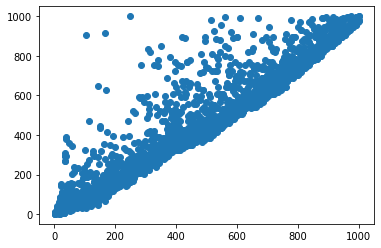

In [3]:
#Are there any missing values?
print('Missing values:', cwur.isnull().values.any())

#How many and in what column?
print('Column and respective missing values: ')
print(cwur.isnull().sum())

#First glance at the data suggests, that the missing value column broad impact seems to correlate with world rank:
plt.scatter(cwur['world_rank'], cwur['broad_impact'])


#Use Encoder to encode categories (country, institution)
encInst = sk.preprocessing.LabelEncoder().fit(cwur['institution'])
encCon = sk.preprocessing.LabelEncoder().fit(cwur['country'])

cwur['institution']  = encInst.transform(cwur['institution'])
cwur['country'] =  encCon.transform(cwur['country'])

#general cutoff for imputation without introducing biass is 3% of rows contained with missing values -> 
#use multivariate imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(cwur)

cwur_imputed = pd.DataFrame(imp.transform(cwur), columns = cwur.columns)





[(-9.0, 1010.0)]

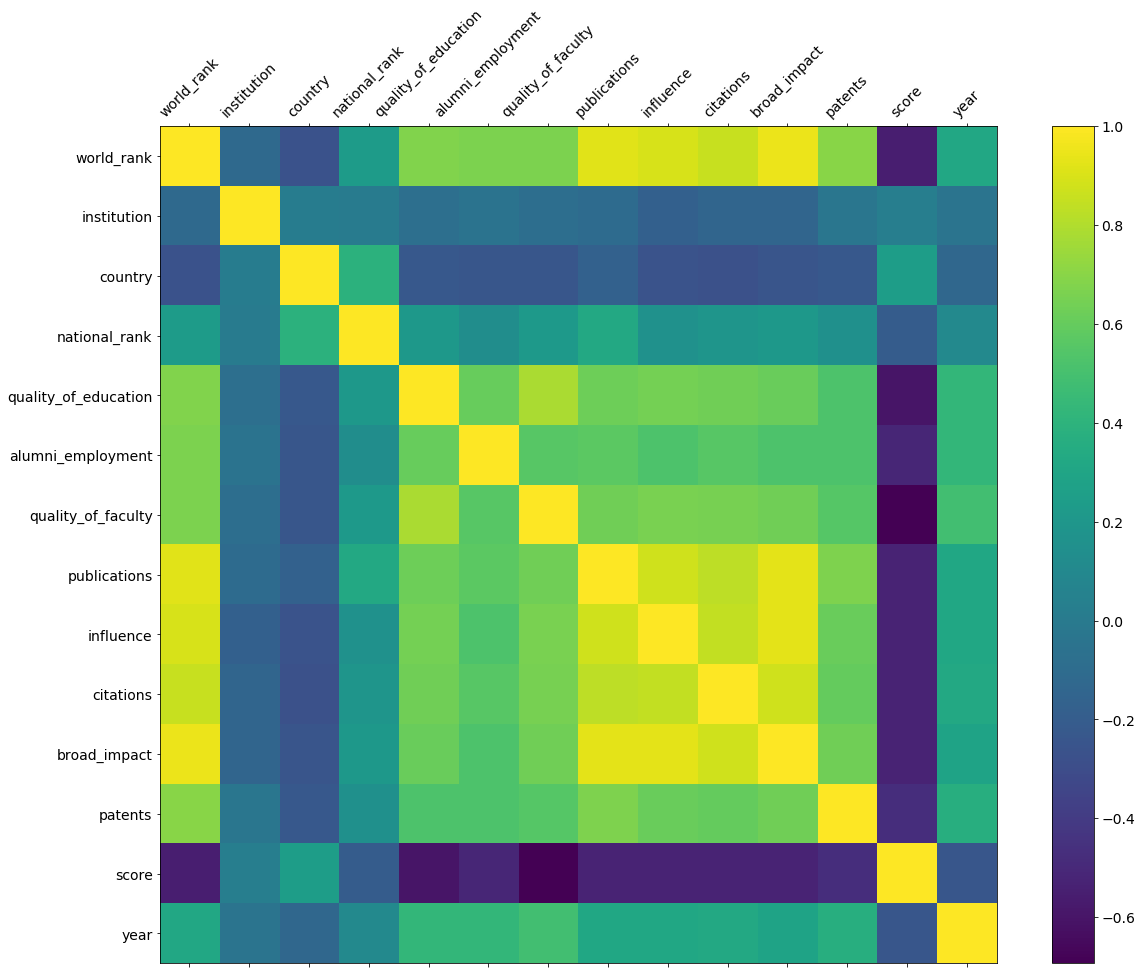

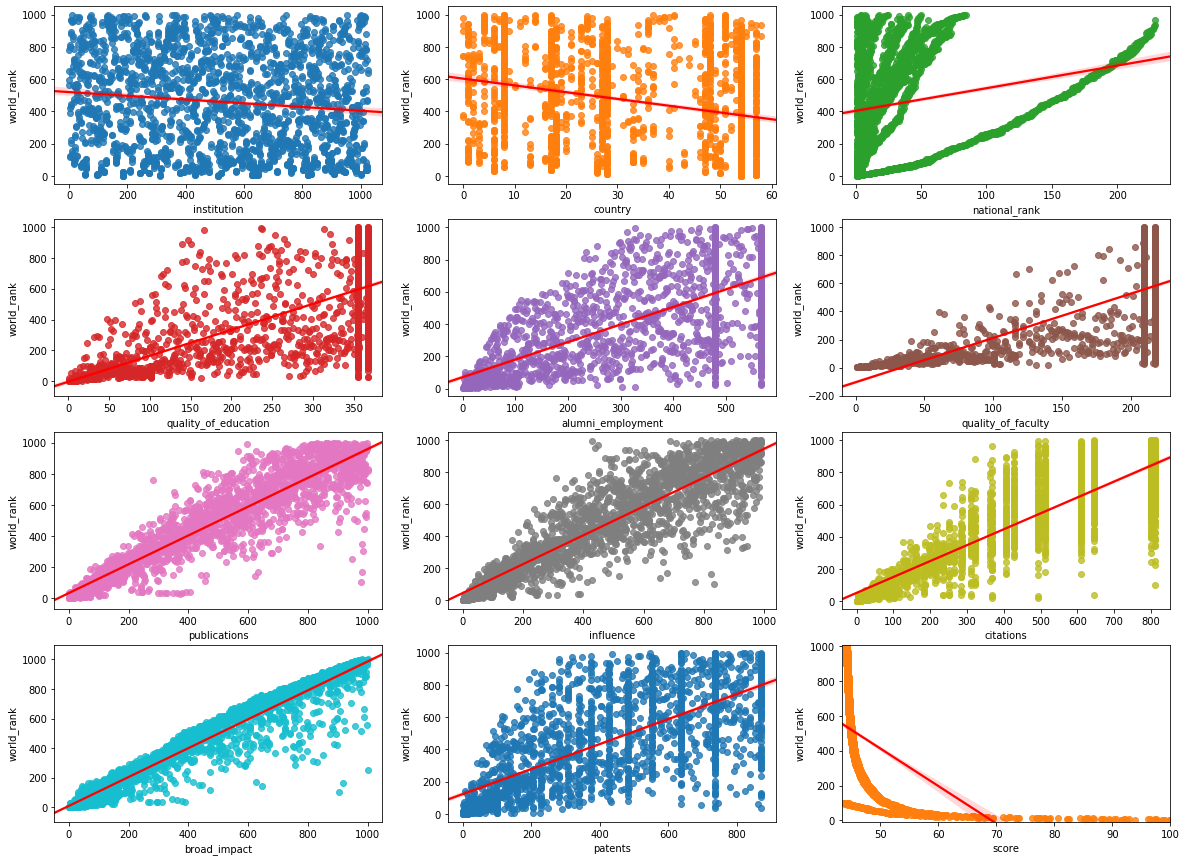

In [4]:
#Visualize Data

#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_imputed.corr(), fignum=fig1.number)
plt.xticks(range(cwur_imputed.shape[1]), cwur_imputed.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_imputed.shape[1]), cwur_imputed.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#scatterplots vs. world rank

fig2, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

sb.regplot(y='world_rank', x='institution', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,0])
sb.regplot(y='world_rank', x='country', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,1])
sb.regplot(y='world_rank', x='national_rank', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,2])

sb.regplot(y='world_rank', x='quality_of_education', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,0])
sb.regplot(y='world_rank', x='alumni_employment', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,1])
sb.regplot(y='world_rank', x='quality_of_faculty', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,2])

sb.regplot(y='world_rank', x='publications', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,0])
sb.regplot(y='world_rank', x='influence', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,1])
sb.regplot(y='world_rank', x='citations', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,2])

sb.regplot(y='world_rank', x='broad_impact', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,0])
sb.regplot(y='world_rank', x='patents', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,1])
sb.regplot(y='world_rank', x='score', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,2])
axs[3,2].set(xlim=(cwur_imputed['score'].min(), cwur_imputed['score'].max()))
axs[3,2].set(ylim=(cwur_imputed['world_rank'].min()-10, cwur_imputed['world_rank'].max()+10))




In [5]:
#we check rankings by region, first we clean the  data so it can be merged with cwur

#first we transform back our label encoding so we can merge
cwur_imputed['country'] = encCon.inverse_transform(cwur['country'])
cwur_imputed['institution'] = encInst.inverse_transform(cwur['institution'])

#rename columns for easier readability
countr_reg = countr_reg.rename(columns={'Country': 'country', 'Region': 'region'})

#strip names off whitespace
countr_reg['country'] = countr_reg['country'].str.strip()
countr_reg['region'] = countr_reg['region'].str.strip()

#remove delete unneeded columns from countr_reg (only country and region columns needed)
countr_reg.drop(countr_reg.columns.difference(['country','region']), 1, inplace=True)
country_check =  cwur_imputed[~cwur_imputed['country'].isin(countr_reg['country'])]

print(country_check.country.unique())

#rename and replace names which don't match
country_dict = {"United States" : "USA",
                "Korea, South" : "South Korea",
                "Slovakia" : "Slovak Republic"}
for key, value in country_dict.items():
    countr_reg.replace(key, value, inplace=True)
    
    
#merge
cwur_countr_reg = pd.merge(cwur_imputed, countr_reg, left_on=['country'], right_on = ['country'])

['USA' 'South Korea' 'Slovak Republic']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

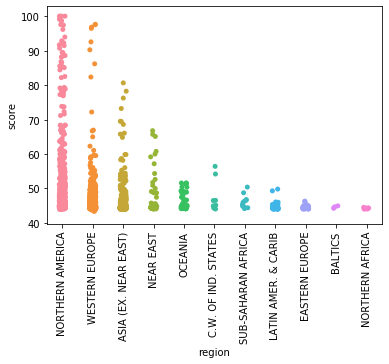

In [6]:
#plot country by region and ranking

sb.stripplot(x="region", y="score", data=cwur_countr_reg, jitter=True)
plt.xticks(rotation=90)

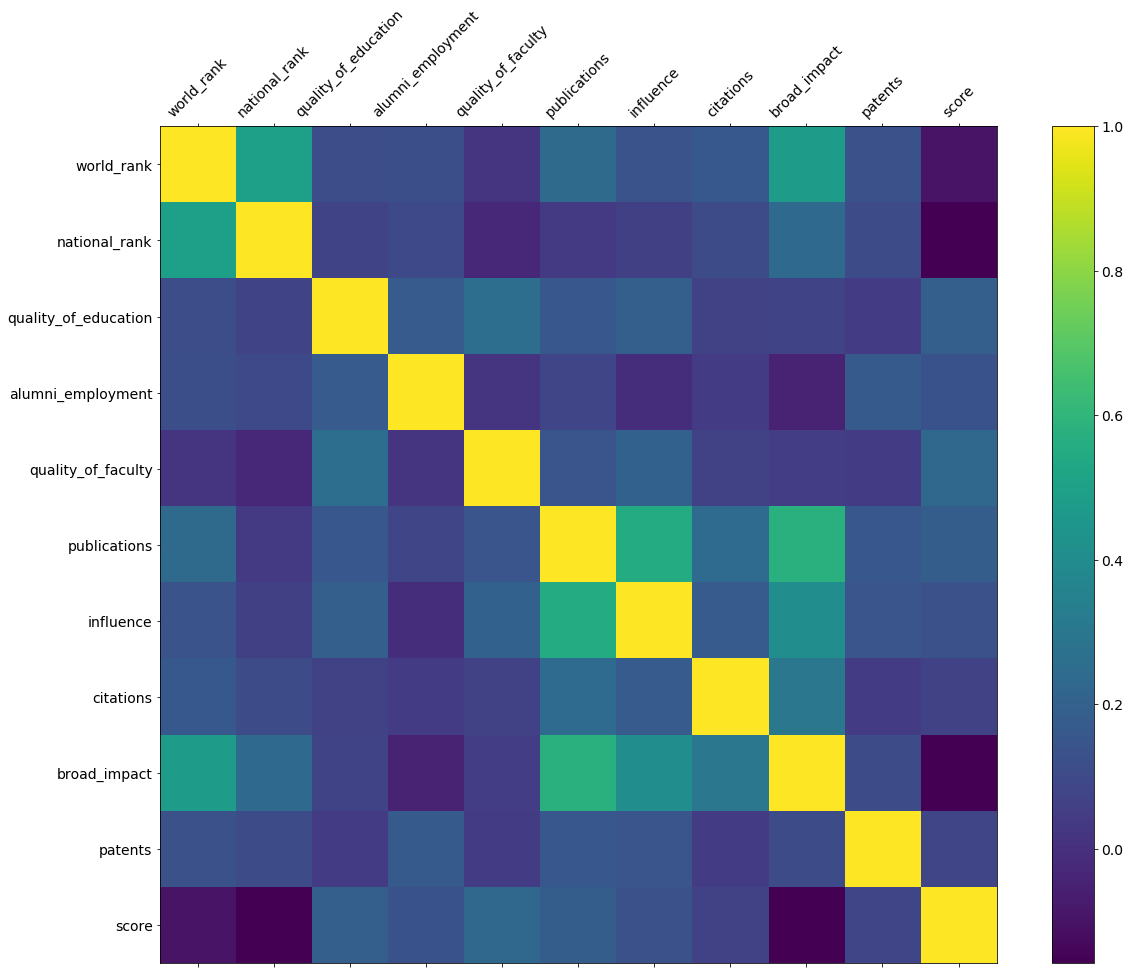

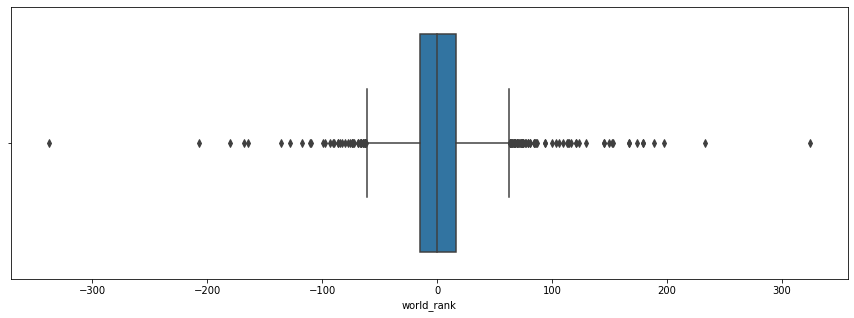

In [7]:
cwur_indexed = cwur_imputed.set_index(['year', 'institution'])


cwur_diff = cwur_indexed.groupby(by='institution').diff()


#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_diff.corr(), fignum=fig1.number)
plt.xticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


fig1 = plt.figure(figsize=(15, 5))
ax = sb.boxplot(x=cwur_diff['world_rank'])



In [8]:


#reformat data so years are columns
hdi_ref = hdi.melt(id_vars=['HDI Rank', 'Country'], var_name='year', value_name='HDI')

hdi_ref['year'] = pd.to_numeric(hdi_ref['year'])


#rename columns for better readability
hdi_ref = hdi_ref.rename(columns={'Country': 'country', 'HDI Rank': 'hdi_rank', 'HDI':'hdi'})

#strip whitespace
hdi_ref['country'] = hdi_ref['country'].str.strip()
#set index
hdi_indexed = hdi_ref.set_index(['year', 'country'])
hdi_indexed = hdi_indexed.loc[(slice(2012, 2015))]

hdi_ref = hdi_indexed.reset_index()


In [9]:


#in this step we merge with cwur_imputed data

#first check if  country names are different in both
country_check =  cwur_imputed[~cwur_imputed['country'].isin(hdi_ref['country'])]
print(country_check.country.unique())

#rename and replace names which don't match
#(no data for taiwan and puerto rico available)
country_dict = {"United States" : "USA",
                "Korea (Republic of)" : "South Korea",
                "Russian Federation" : "Russia",
                "Iran (Islamic Republic of)":"Iran",
                "Hong Kong, China (SAR)":"Hong Kong",
                "Czechia": "Czech Republic",
                "Slovakia" : "Slovak Republic"}
for key, value in country_dict.items():
    hdi_ref.replace(key, value, inplace=True)



#merge
cwur_hdi = pd.merge(cwur_imputed, hdi_ref, left_on=['year','country'], right_on = ['year','country'])


['USA' 'South Korea' 'Russia' 'Taiwan' 'Hong Kong' 'Czech Republic'
 'Slovak Republic' 'Iran' 'Puerto Rico']


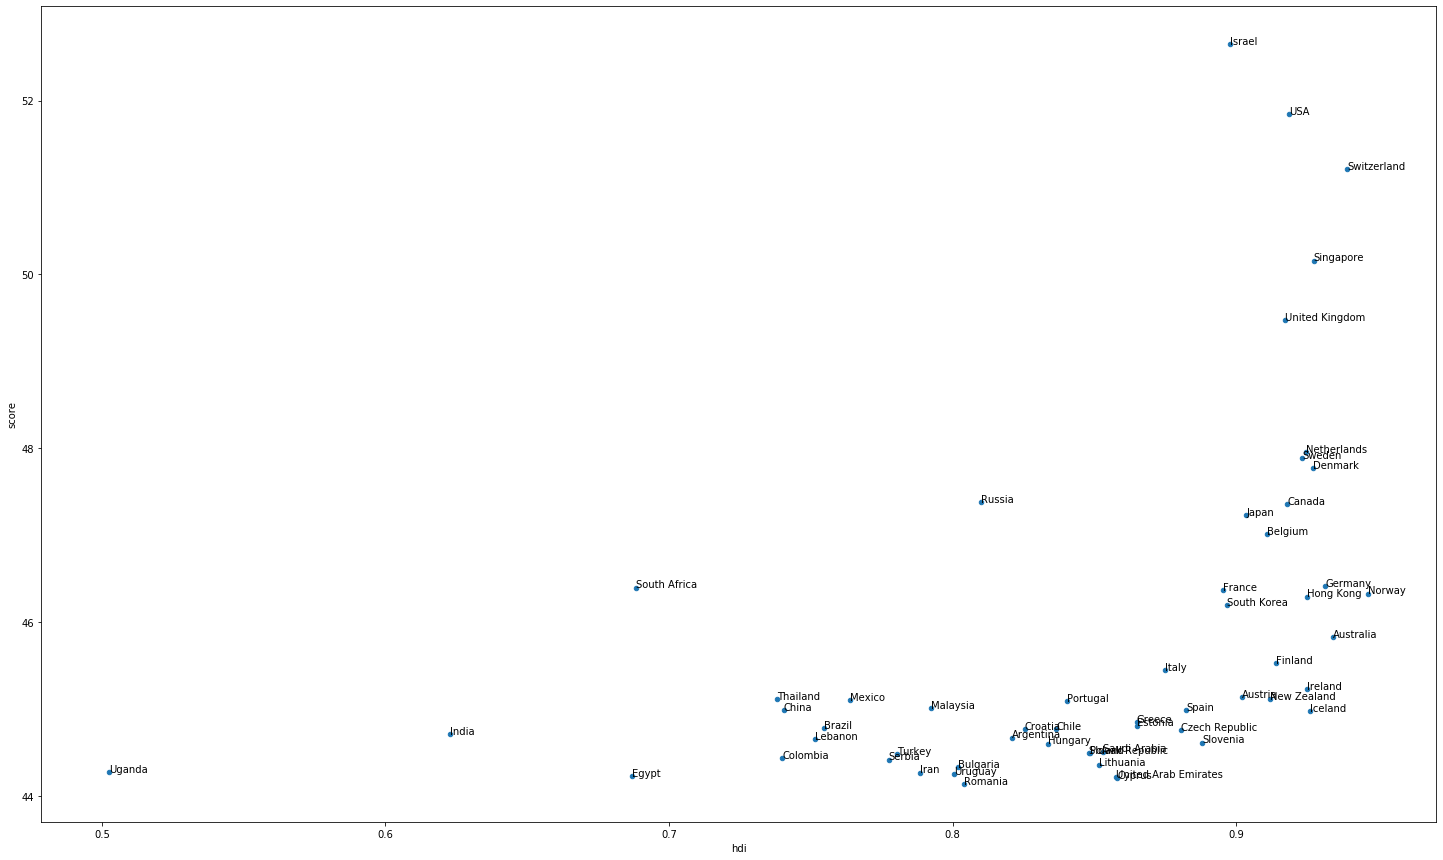

In [10]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby("country").mean()

fig, ax = plt.subplots()
cwur_hdi_mean.plot("hdi", "score", kind="scatter",
             figsize = (25,15), ax=ax)

for k, v in cwur_hdi_mean.iterrows():
    x = v["hdi"]
    y = v["score"]
    ax.annotate(k, (x,y))
      
plt.show()


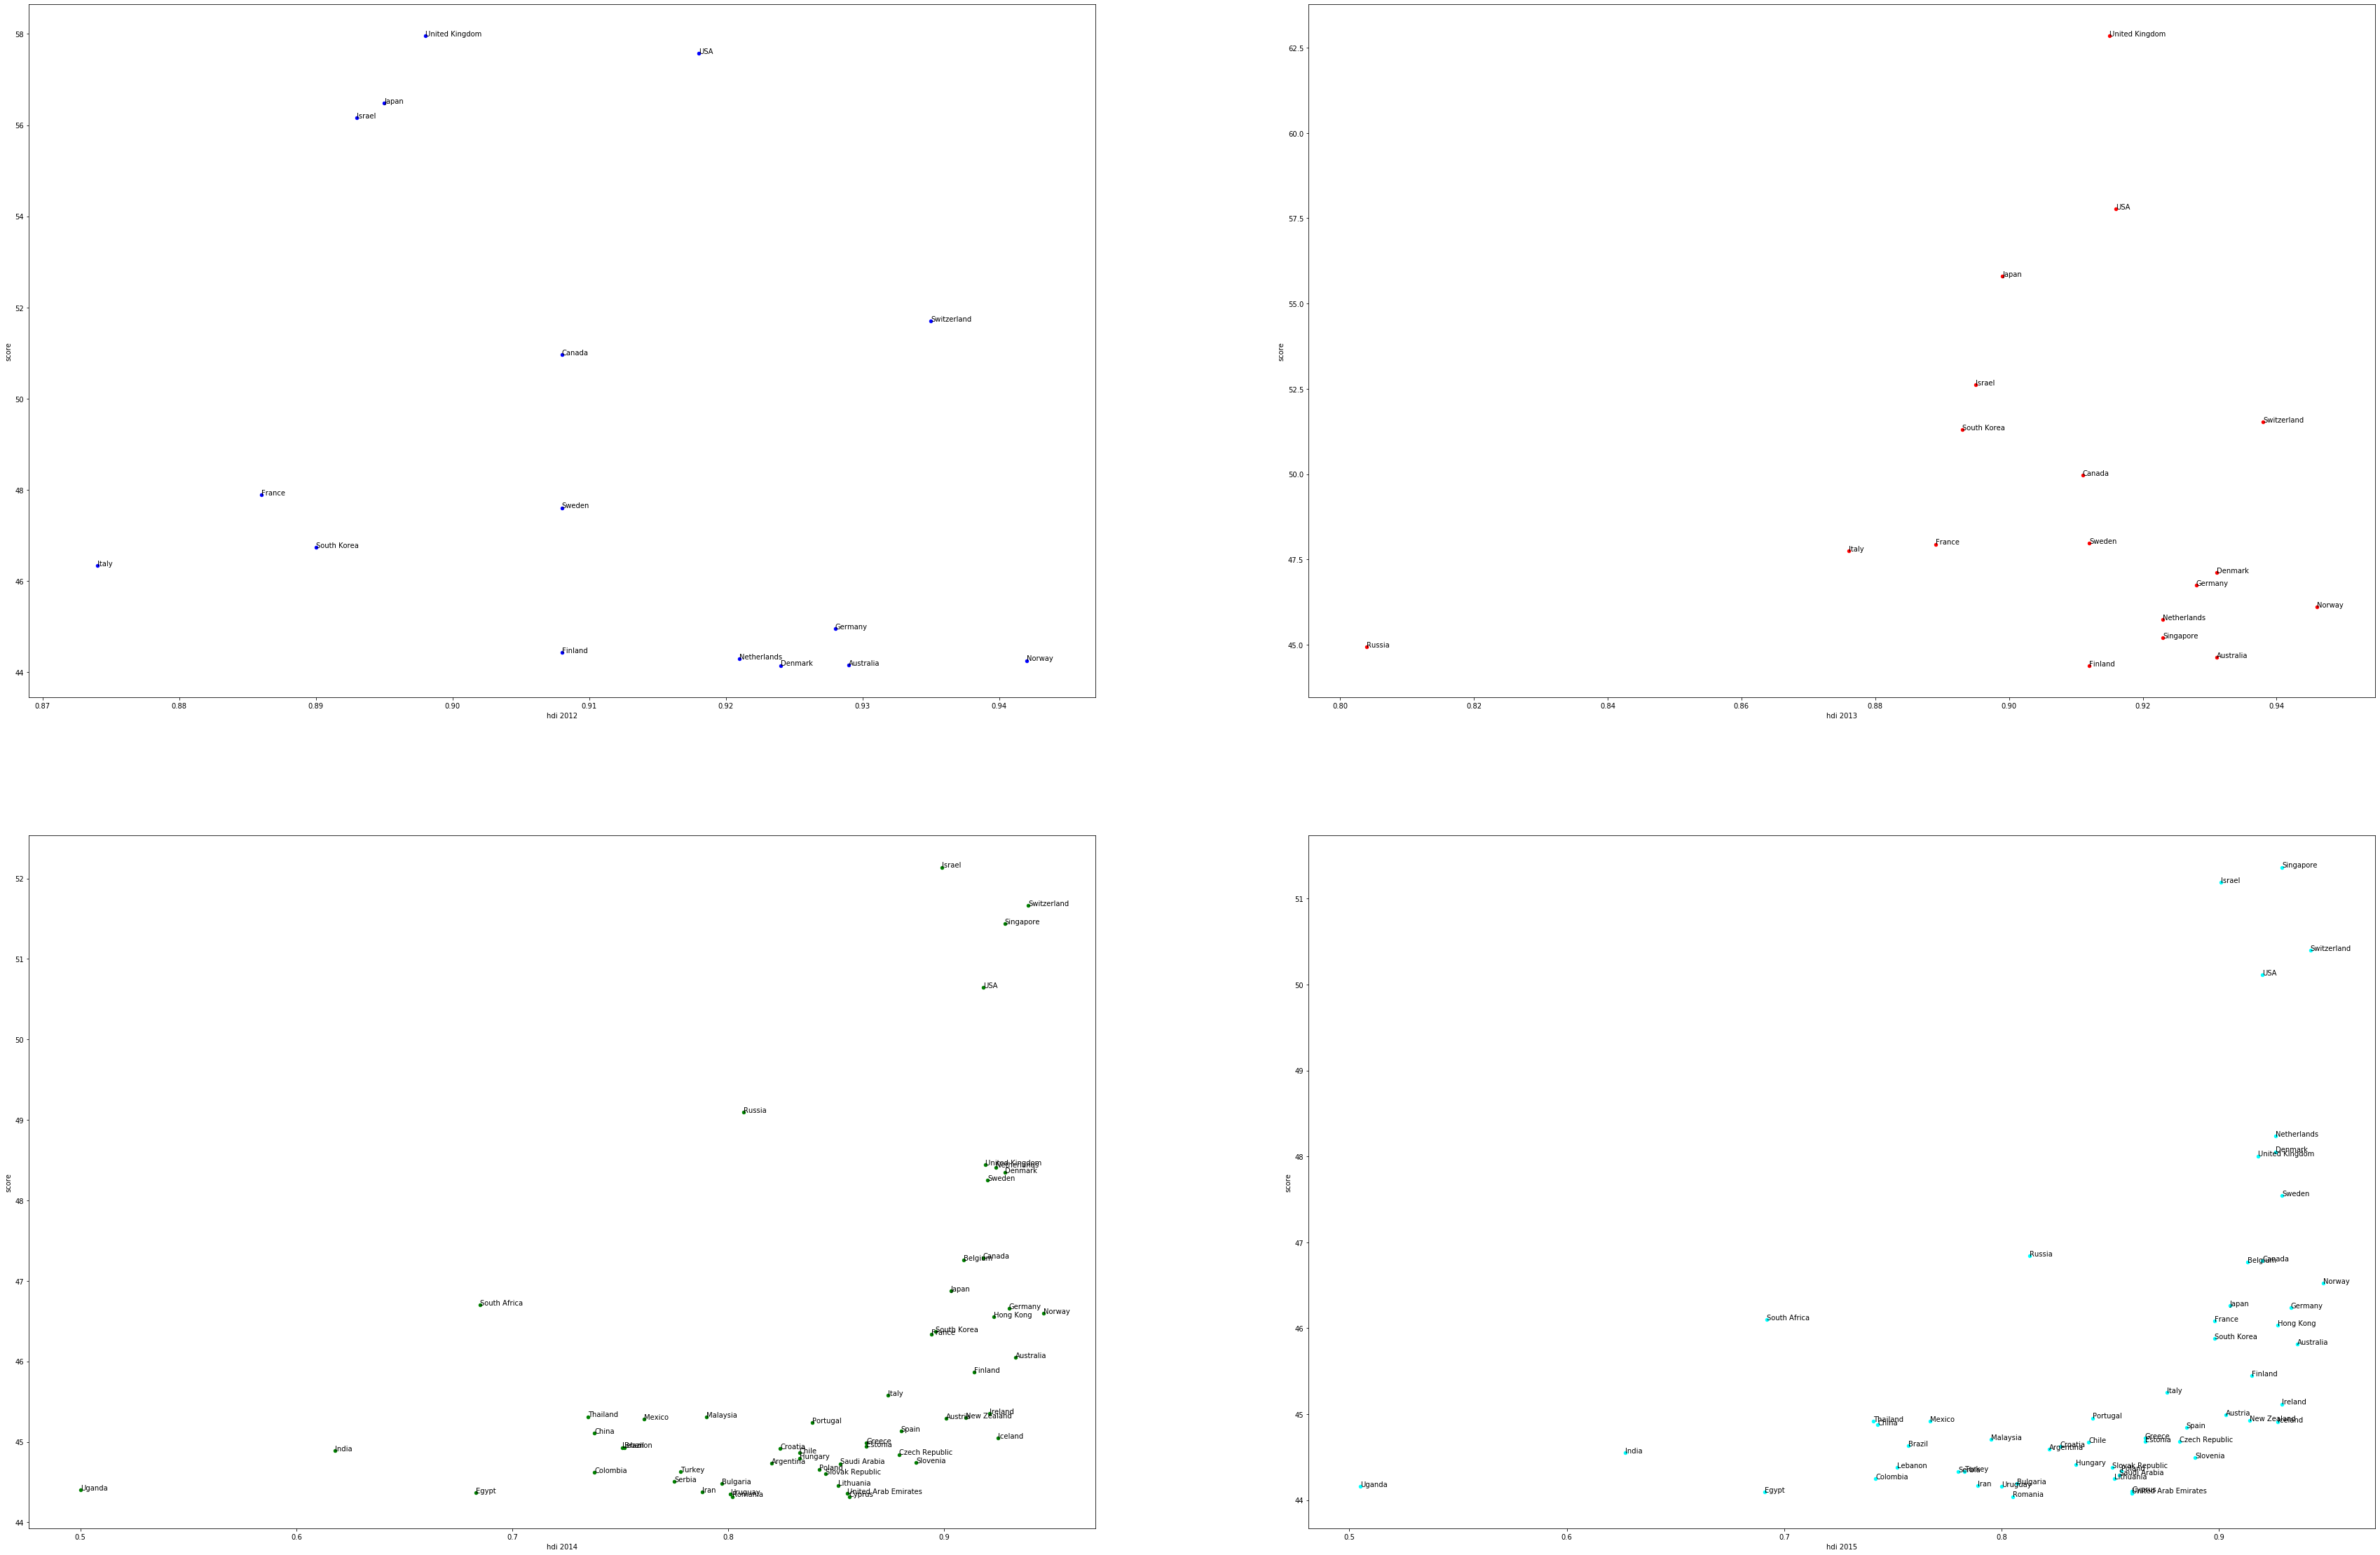

In [79]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby(["year", "country"]).mean()
cwur_hdi_mean12 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2012.0]
cwur_hdi_mean13 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2013.0]
cwur_hdi_mean14 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2014.0]
cwur_hdi_mean15 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2015.0]

fig, axs = plt.subplots(nrows=2, ncols=2)
cwur_hdi_mean12.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[0,0], color = "blue")
axs[0,0].set_xlabel("hdi 2012")


for k, v in cwur_hdi_mean12.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[0,0].annotate(k[1], (x,y))

cwur_hdi_mean13.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[0,1], color = "red")
axs[0,1].set_xlabel("hdi 2013")
for k, v in cwur_hdi_mean13.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[0,1].annotate(k[1], (x,y))

cwur_hdi_mean14.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[1,0], color = "green")
axs[1,0].set_xlabel("hdi 2014")
for k, v in cwur_hdi_mean14.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[1,0].annotate(k[1], (x,y))

cwur_hdi_mean15.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[1,1], color = "cyan")
axs[1,1].set_xlabel("hdi 2015")
for k, v in cwur_hdi_mean15.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[1,1].annotate(k[1], (x,y))
    
    
plt.show()


In [80]:
#log data for better correlation


In [108]:
hdi_score = cwur_hdi_mean[[ 'hdi', 'world_rank']]


#encode categorical variable for model training
#hdi_score['institution']  = encInst.transform(hdi_score['institution'])
#hdi_score['country'] =  encCon.transform(hdi_score['country'])

# y is the actual data we want to predict
y = np.array(hdi_score['world_rank'])

#drop data we want to predict from table
x= hdi_score.drop(('world_rank'), axis = 1)

# Convert to numpy array
x = np.array(x)

# Save feature names for visualization later
feature_list = list(hdi_score.columns)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.8, random_state = 101)

print('Training Features Shape:', train_x.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing Labels Shape:', test_y.shape)
#hdi_score

Training Features Shape: (29, 1)
Training Labels Shape: (29,)
Testing Features Shape: (119, 1)
Testing Labels Shape: (119,)


In [109]:
#train model

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

#fit model
rf.fit(train_x, train_y)


#predict
pred = rf.predict(test_x)

In [110]:
#check performance metrics


error = abs(pred - test_y)

#calculate mean error to see how much our average estimate is off by
print('Mean Absolute Error:', round(np.mean(error), 2), 'degrees.')
rf.score(pred.reshape(-1,1),test_y.reshape(-1,1))





Mean Absolute Error: 188.35 degrees.


-1.2336424711648108

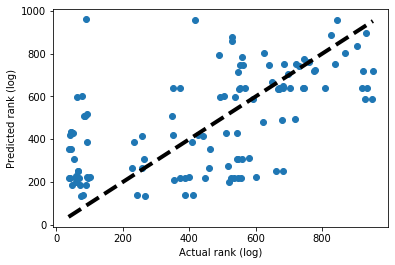

In [111]:
fig, ax = plt.subplots()
ax.scatter(test_y, pred)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual rank (log)')
ax.set_ylabel('Predicted rank (log)')
plt.show()
